<div style="border-radius: 15px; border: 2px solid #2e8b57; padding: 20px; background-color: #b9fbc0; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); font-family: sans-serif;">

  <div style="text-align: center; margin-bottom: 20px;">
    <img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="300" alt="Logo FIUBA">
  </div>

  <h1 style="color: #2e8b57; text-align: center; text-shadow: 1px 1px 3px rgba(0,0,0,0.3); font-size: 28px; margin-bottom: 10px;">
    TRABAJO FINAL INTEGRADOR
  </h1>

  <div style="text-align: center;">
    <h2 style="color: #2e8b57; margin: 0; font-weight: normal;">VISI√ìN POR COMPUTADORA II</h2>
    <h3 style="color: #2e8b57; margin-top: 5px; margin-bottom: 20px; font-weight: normal;">Chest CT-Scan images Dataset 2025</h3>
  </div>

  <hr style="border: none; height: 2px; background-color: #2e8b57; margin: 20px 0;">

  <div style="color: #004d40; font-size: 16px; font-weight: bold; margin-bottom: 5px;">ALUMNOS:</div>
  <ul style="color: #004d40; font-size: 16px; margin-top: 0; padding-left: 20px;">
    <li>Mauro Fabian Barquinero</li>
    <li>Juan Cruz Ojeda</li>
    <li>Mariano Campos</li>
    <li>Jose Luis Perez Galindo</li>
  </ul>

  <hr style="border: none; height: 1px; background-color: #2e8b57; margin: 20px 0;">

  <div style="text-align: center;">
    <a href="https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images" target="_blank"
       style="background-color: #2e8b57; color: white; padding: 10px 20px; text-decoration: none; border-radius: 8px; box-shadow: 1px 1px 4px rgba(0,0,0,0.3); font-weight: bold; display: inline-block;">
      ENLACE DATASET
    </a>
  </div>

</div>



<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Descripci√≥n del problema</h1>
</div>


El presente trabajo se enfoca en la detecci√≥n autom√°tica de n√≥dulos pulmonares a partir de im√°genes de tomograf√≠a computada (CT) de t√≥rax. Esta problem√°tica reviste gran importancia en contextos cl√≠nicos, donde un diagn√≥stico temprano puede mejorar significativamente el pron√≥stico de los pacientes. Dado el car√°cter m√©dico de las im√°genes, se requiere especial atenci√≥n en el preprocesamiento y en la selecci√≥n del modelo, priorizando el *recall* sobre otras m√©tricas para evitar falsos negativos.

## Cargar bibliotecas

In [32]:
# Librer√≠as est√°ndar de Python
import os
import shutil
import zipfile
from pathlib import Path
from collections import defaultdict

# Procesamiento de datos y visualizaci√≥n
import numpy as np           # Operaciones num√©ricas
import pandas as pd          # Manipulaci√≥n de dataframes
import matplotlib.pyplot as plt  # Gr√°ficos
import seaborn as sns            # Visualizaci√≥n estad√≠stica
from PIL import Image            # Manejo de im√°genes

# OpenCV para procesamiento de im√°genes
import cv2                      # Visi√≥n por computadora tradicional

# Scikit-learn para machine learning tradicional
from sklearn.ensemble import RandomForestClassifier  # Clasificador cl√°sico
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # Optimizaci√≥n de hiperpar√°metros
from sklearn.preprocessing import LabelEncoder       # Codificaci√≥n de etiquetas
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer  # M√©tricas

# Utilidades adicionales
from tqdm import tqdm         # Barra de progreso
import joblib                 # Guardado y carga de modelos

# Semilla para reproducibilidad de los experimentos
np.random.seed(42)


---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">An√°lisis de la estructura del dataset</h1>
</div>

## Verificar las carpetas del dataset

In [33]:
# Descomprimir archive.zip en el directorio actual (si existe)
if os.path.exists("archive.zip"):
    with zipfile.ZipFile("archive.zip", "r") as zip_ref:
        zip_ref.extractall(".")


# Path del directorio
data_dir = os.path.join(".", "Data")

# Verificamos que el directorio exista
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"No se encontr√≥ el directorio: {data_dir}")

# Listar las clases dentro de cada subconjunto: train, test y valid
subsets = ['train', 'test', 'valid']

for subset in subsets:
    subset_path = os.path.join(data_dir, subset)
    if not os.path.exists(subset_path):
        print(f"[ADVERTENCIA] No se encontr√≥ el subdirectorio: {subset_path}")
        continue
    classes = os.listdir(subset_path)
    print(f"\n{subset.upper()}:")
    for cls in classes:
        print(f"  - {cls}")


TRAIN:
  - adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
  - large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
  - normal
  - squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa

TEST:
  - adenocarcinoma
  - large.cell.carcinoma
  - normal
  - squamous.cell.carcinoma

VALID:
  - adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
  - large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
  - normal
  - squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


---

Como podemos observar, los nombres de las carpetas correspondientes a los subtipos de c√°ncer presentan inconsistencias significativas. Mientras que en los conjuntos `TRAIN` y `VALID` se utilizan nombres extensos que incluyen informaci√≥n anat√≥mica y estadios cl√≠nicos (por ejemplo, `adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib`), en `TEST` los nombres aparecen abreviados o truncados (por ejemplo, `adenocarcinoma`, `large.cell.carcinoma`).

Esta disparidad genera m√∫ltiples inconvenientes:

- Dificulta la unificaci√≥n de clases al momento de entrenar modelos de clasificaci√≥n.
- Puede inducir a errores en el proceso de etiquetado o evaluaci√≥n si no se realiza un mapeo previo.
- Aumenta el riesgo de duplicaci√≥n o fragmentaci√≥n de clases al momento de vectorizar los datos.

Por lo tanto, resulta fundamental estandarizar la nomenclatura de las clases. Una estrategia posible consiste en mapear todos los nombres detallados a una versi√≥n abreviada y uniforme, tal como:

- `adenocarcinoma`
- `large.cell.carcinoma`
- `squamous.cell.carcinoma`
- `normal`

Este paso de limpieza debe realizarse antes de cualquier proceso de entrenamiento para garantizar la coherencia en los datos y evitar sesgos o errores de clasificaci√≥n.

---


 ## Visualizar las im√°genes por clases.


üìÇ train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib:


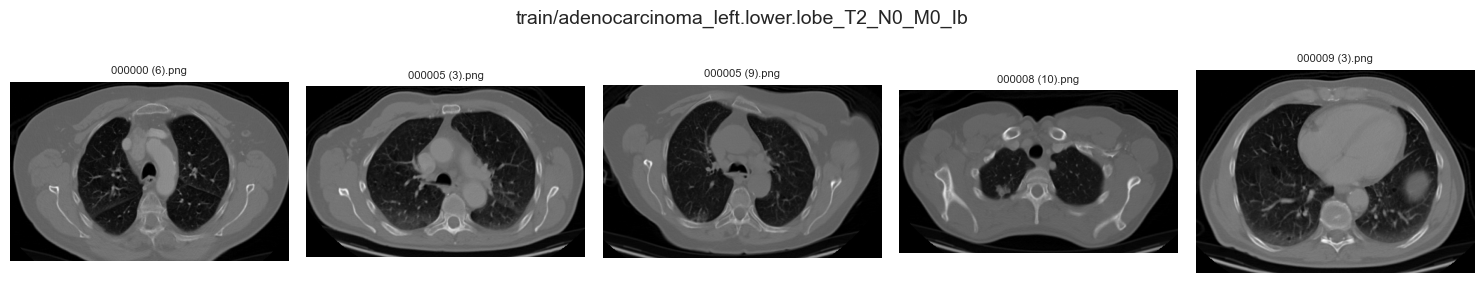


üìÇ train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa:


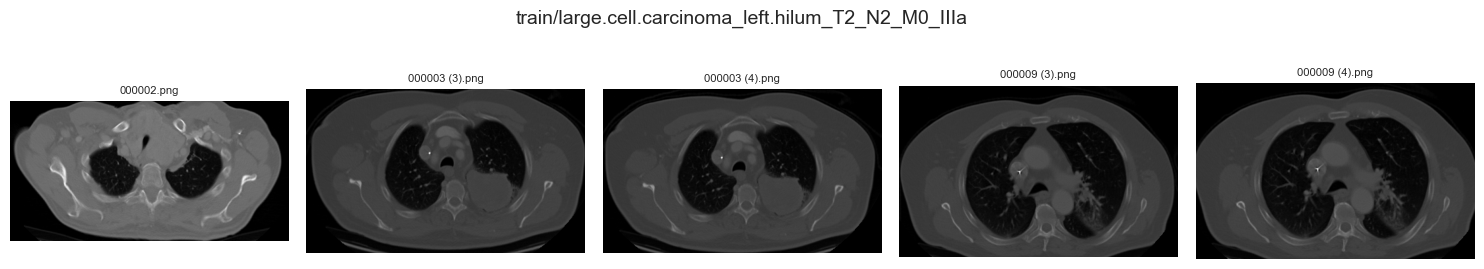


üìÇ train/normal:


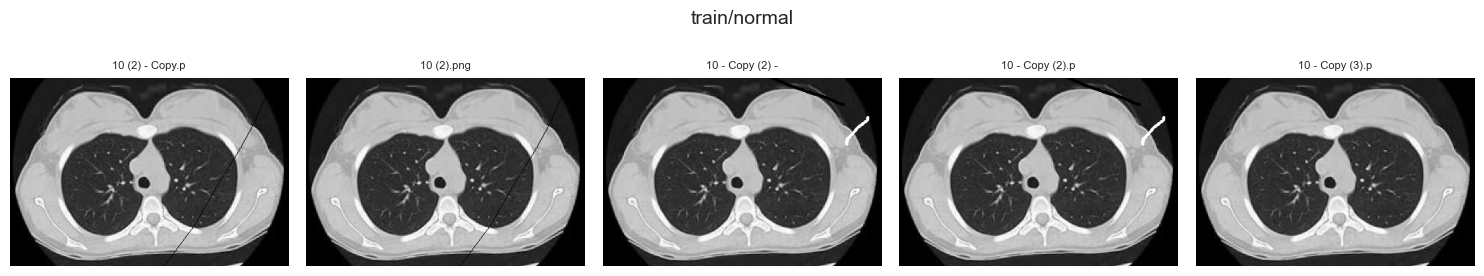


üìÇ train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa:


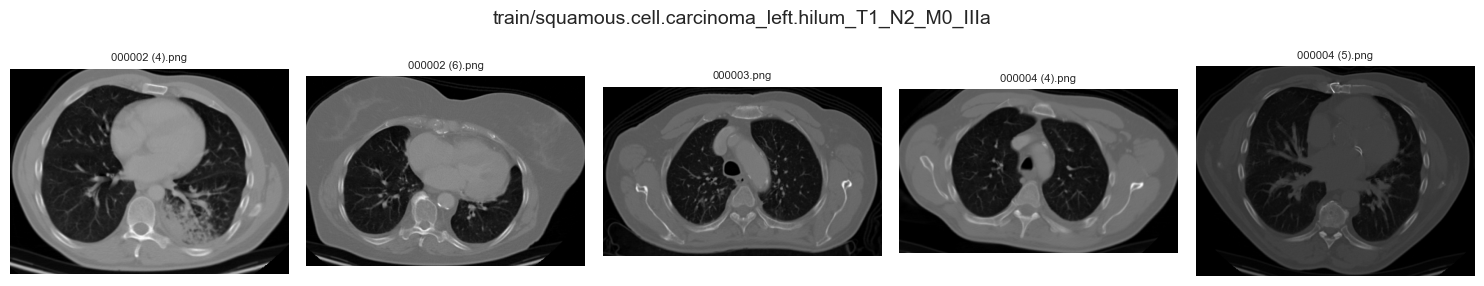


üìÇ valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib:


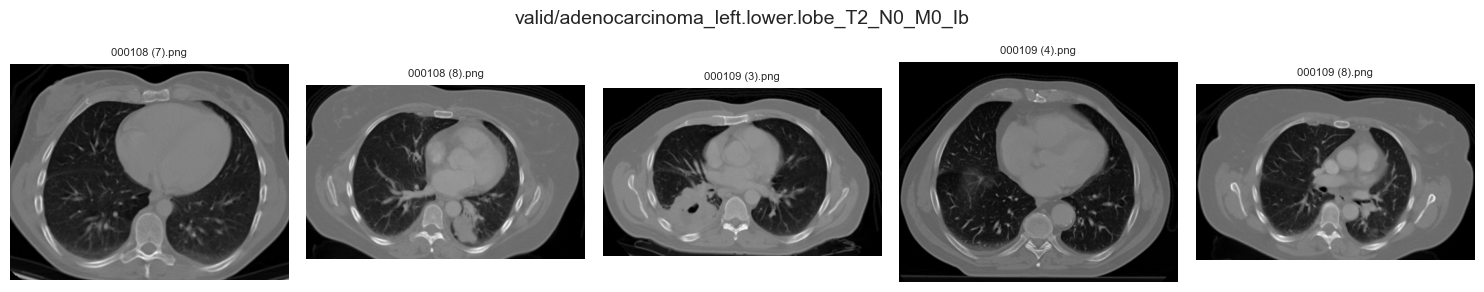


üìÇ valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa:


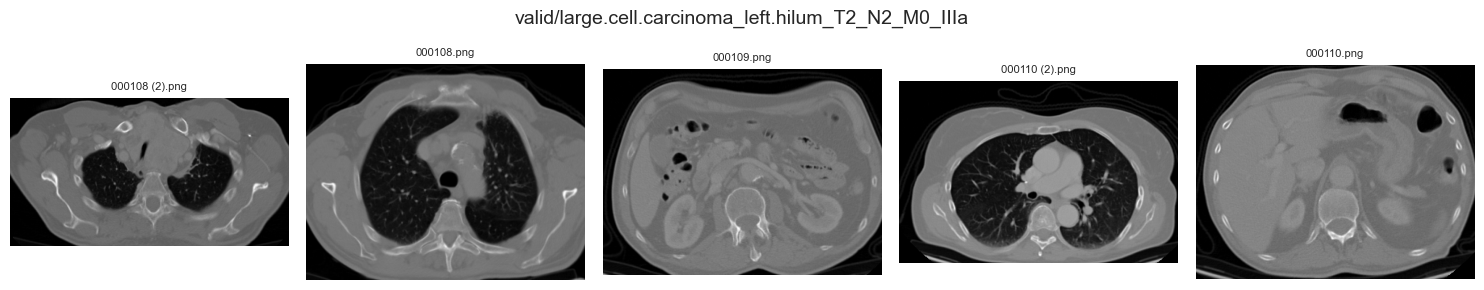


üìÇ valid/normal:


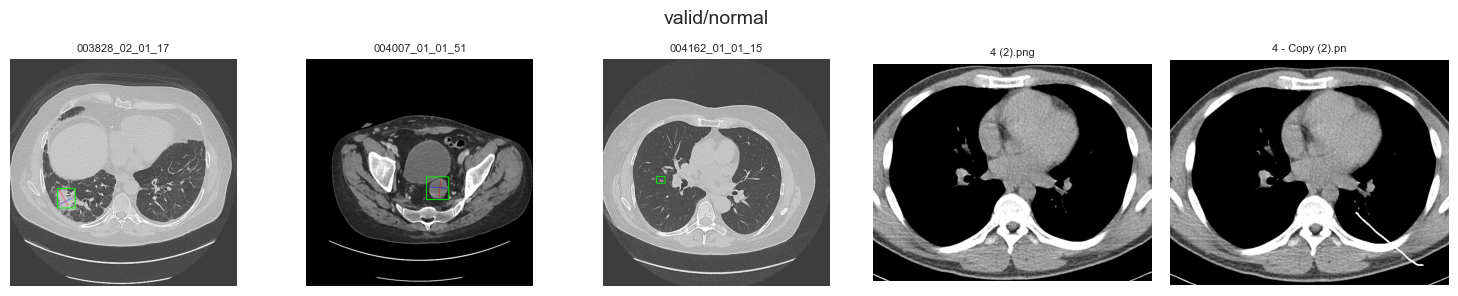


üìÇ valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa:


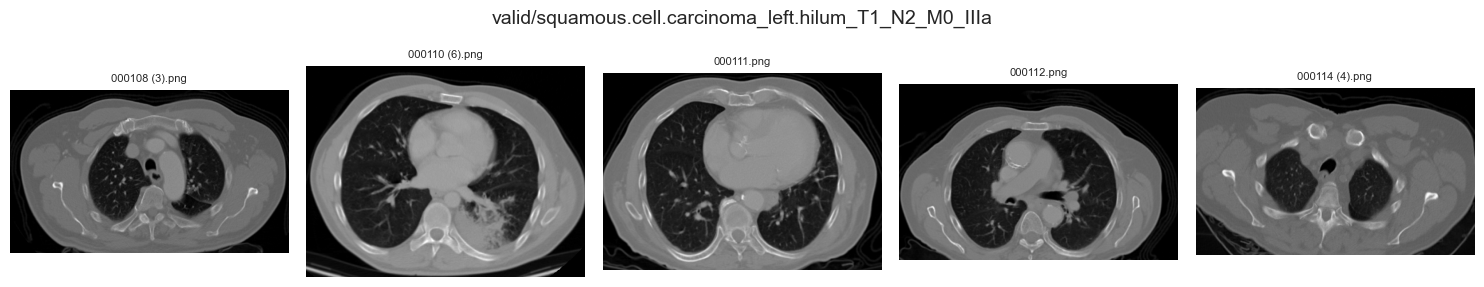


üìÇ test/adenocarcinoma:


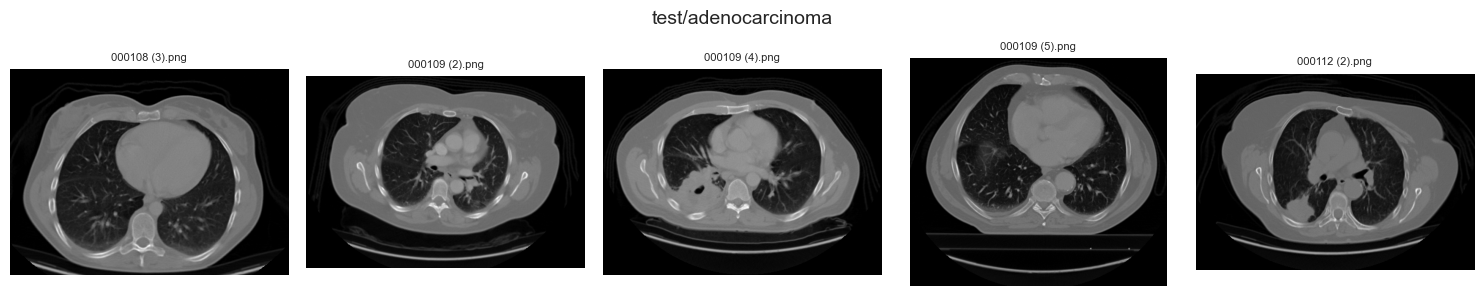


üìÇ test/large.cell.carcinoma:


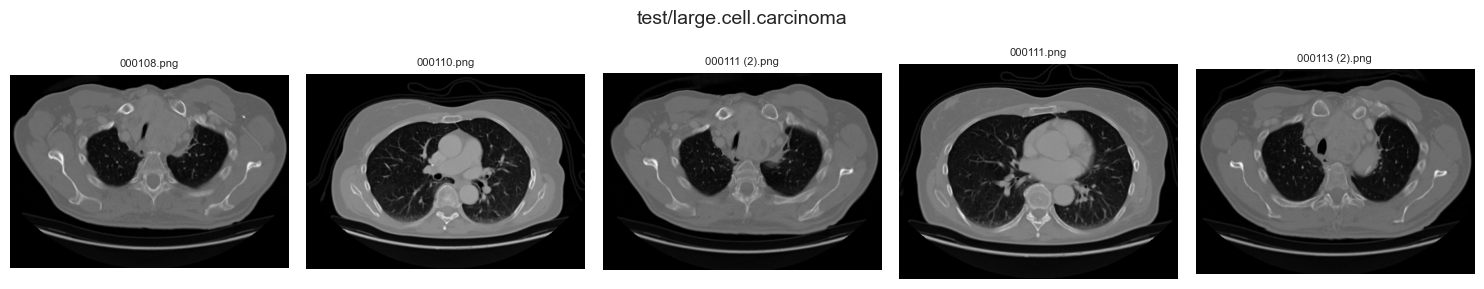


üìÇ test/normal:


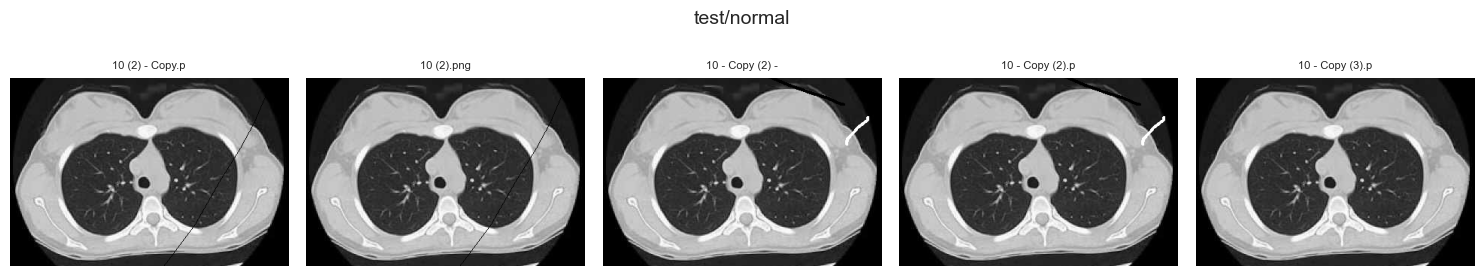


üìÇ test/squamous.cell.carcinoma:


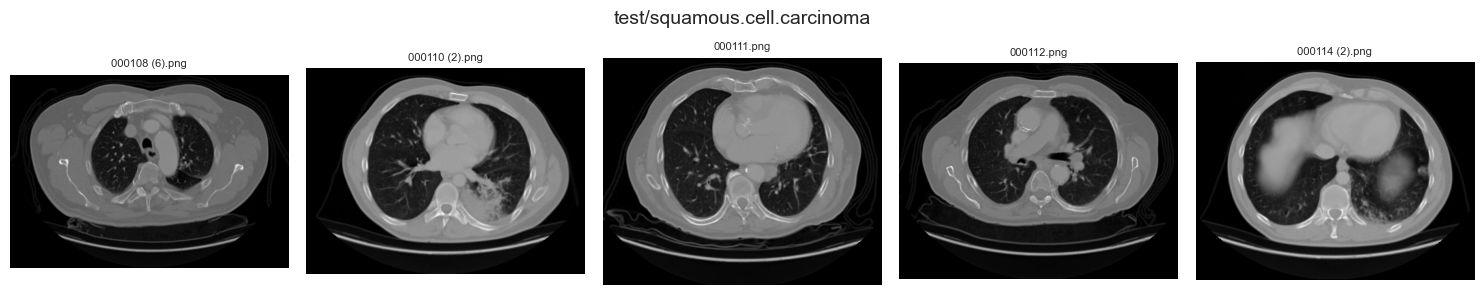

In [34]:
dataset_root = Path("./Data")

# Funci√≥n para mostrar im√°genes por subcarpeta sin importar el label
def mostrar_5_imagenes_por_subcarpeta(data_dir, subsets=["train", "valid", "test"]):
    for subset in subsets:
        subset_path = Path(data_dir) / subset
        if not subset_path.exists():
            print(f"[ADVERTENCIA] No existe el directorio {subset_path}")
            continue

        subfolders = [f for f in subset_path.iterdir() if f.is_dir()]
        for subfolder in subfolders:
            image_files = sorted([f for f in subfolder.iterdir() if f.is_file()])[:5]
            if not image_files:
                continue

            print(f"\nüìÇ {subset}/{subfolder.name}:")
            fig, axes = plt.subplots(1, len(image_files), figsize=(3 * len(image_files), 3))
            fig.suptitle(f"{subset}/{subfolder.name}", fontsize=14)

            if len(image_files) == 1:
                axes = [axes]

            for i, img_path in enumerate(image_files):
                img = cv2.imread(str(img_path))
                if img is None:
                    axes[i].axis("off")
                    axes[i].set_title("Error de lectura", fontsize=8)
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
                axes[i].axis("off")
                axes[i].set_title(img_path.name[:15], fontsize=8)

            plt.tight_layout()
            plt.show()

# Ejecutar la funci√≥n
mostrar_5_imagenes_por_subcarpeta(dataset_root)

---

Se realiz√≥ una inspecci√≥n sobre las im√°genes del dataset y se pudo constatar que, en el caso de los distintos tipos de c√°ncer, no existen duplicados. Las im√°genes que comparten el mismo identificador num√©rico corresponden al mismo estudio tor√°cico, pero capturado desde diferentes cortes o √°ngulos. Esta diversidad de vistas permite una mejor visualizaci√≥n y an√°lisis de la enfermedad desde distintas perspectivas.

Durante el an√°lisis tambi√©n se detectaron im√°genes con nombres similares (como aquellas que contienen copy o (2)), especialmente en la clase normal. Aunque algunas pueden parecer duplicadas, presentan peque√±as diferencias como anotaciones, marcas o variaciones de contraste. Estas diferencias enriquecen el conjunto de datos con ejemplos m√°s realistas, por lo que se decidi√≥ conservar todas las im√°genes.

A continuaci√≥n se presentan dos ejemplos representativos de esta situaci√≥n.

---

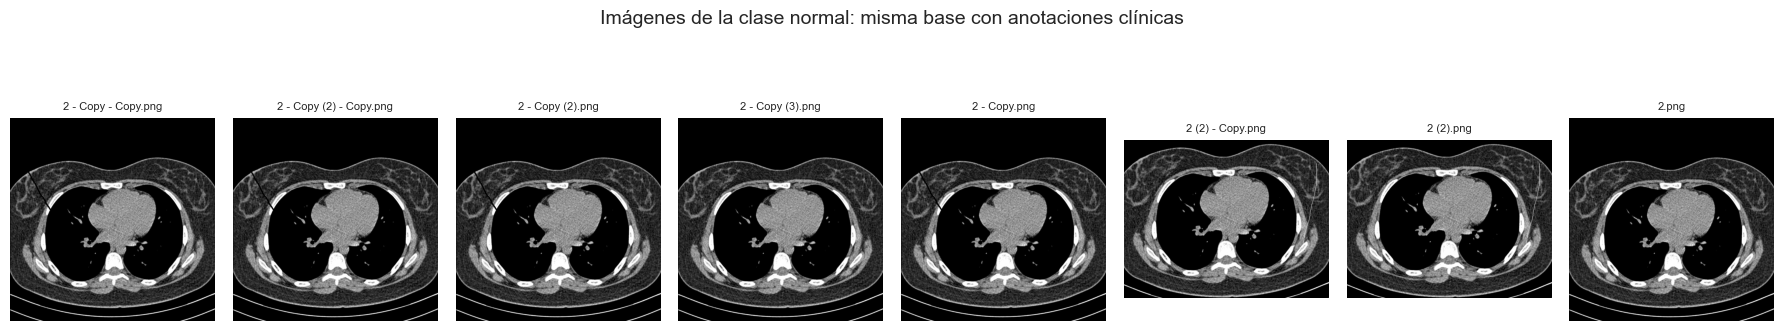

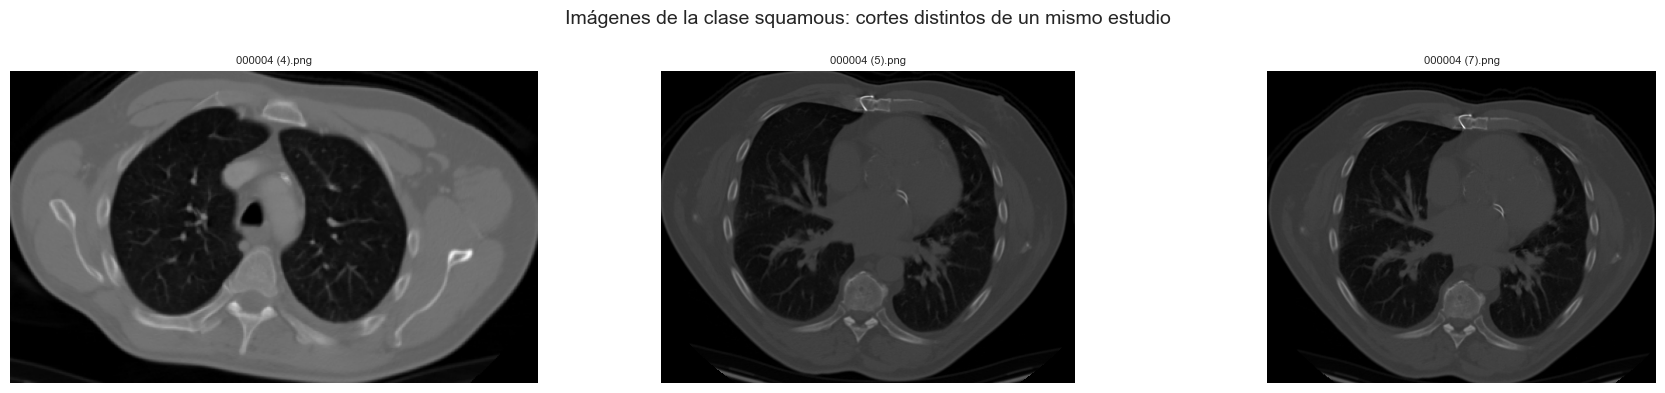

In [35]:
def mostrar_imagenes_por_nombres(ruta_clase, nombres_archivos, titulo_fila):
    fig, axes = plt.subplots(1, len(nombres_archivos), figsize=(18, 4))
    fig.suptitle(titulo_fila, fontsize=14)

    for ax, nombre in zip(axes, nombres_archivos):
        ruta_img = Path(ruta_clase) / nombre
        with Image.open(ruta_img) as img:
            ax.imshow(img, cmap='gray')
            ax.set_title(nombre, fontsize=8)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Carpeta base
base_path = "Data/train"

# Im√°genes de la clase 'normal'
imagenes_normal = [
    "2 - Copy - Copy.png",
    "2 - Copy (2) - Copy.png",
    "2 - Copy (2).png",
    "2 - Copy (3).png",
    "2 - Copy.png",
    "2 (2) - Copy.png",
    "2 (2).png",
    "2.png"
]
mostrar_imagenes_por_nombres(
    ruta_clase=f"{base_path}/normal",
    nombres_archivos=imagenes_normal,
    titulo_fila="Im√°genes de la clase normal: misma base con anotaciones cl√≠nicas"
)

# Im√°genes de la clase 'squamous'
imagenes_squamous = [
    "000004 (4).png",
    "000004 (5).png",
    "000004 (7).png"
]

base_path = Path(base_path) 

# Opciones de carpeta posibles
carpetas_opcionales = [
    "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa",
    "squamous.cell.carcinoma"
]

# Buscar la primera carpeta existente
ruta_clase = None
for nombre in carpetas_opcionales:
    posible_ruta = base_path / nombre
    if posible_ruta.exists():
        ruta_clase = posible_ruta
        break

if ruta_clase is None:
    print("No se encontr√≥ ninguna de las carpetas esperadas.")
else:
    mostrar_imagenes_por_nombres(
        ruta_clase=ruta_clase,
        nombres_archivos=imagenes_squamous,
        titulo_fila="Im√°genes de la clase squamous: cortes distintos de un mismo estudio"
    )


---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Limpieza</h1>
</div>

> **Nota:**  
> Como se observ√≥, los nombres de las carpetas correspondientes a los subtipos de c√°ncer presentan inconsistencias significativas entre los conjuntos de datos. Este tipo de disparidades no solo dificulta el procesamiento automatizado, sino que tambi√©n puede inducir errores en la interpretaci√≥n de etiquetas.  
> 
> Por ello, resulta fundamental realizar una estandarizaci√≥n previa a cualquier tarea de entrenamiento. La adopci√≥n de una nomenclatura uniforme no solo facilita la manipulaci√≥n de los datos, sino que adem√°s asegura la coherencia sem√°ntica entre las clases utilizadas para el aprendizaje del modelo.


## Se procede a generalizar los nombres de las carpetas

In [36]:
# Definir etiquetas v√°lidas
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Funci√≥n para encontrar el nombre de etiqueta a partir del nombre de carpeta
def find_label_from_folder(folder_name, labels):
    for label in labels:
        if folder_name.startswith(label):
            return label
    return None

# Particiones donde renombrar carpetas
splits_to_fix = ["train", "valid"]
base_path = os.path.join(".", "Data")

# Renombrar carpetas
for split in splits_to_fix:
    split_path = os.path.join(base_path, split)
    for folder_name in os.listdir(split_path):
        full_path = os.path.join(split_path, folder_name)
        if not os.path.isdir(full_path):
            continue
        label = find_label_from_folder(folder_name, labels)
        if label and folder_name != label:
            new_path = os.path.join(split_path, label)
            if not os.path.exists(new_path):
                shutil.move(full_path, new_path)
            else:
                # Si ya existe, mover los archivos a la carpeta correcta y eliminar la original
                for file in os.listdir(full_path):
                    shutil.move(os.path.join(full_path, file), os.path.join(new_path, file))
                os.rmdir(full_path)

# Verificamos la nueva estructura
fixed_structure = {}
for split in splits_to_fix:
    split_path = os.path.join(base_path, split)
    fixed_structure[split] = sorted(os.listdir(split_path))

fixed_structure

{'train': ['adenocarcinoma',
  'large.cell.carcinoma',
  'normal',
  'squamous.cell.carcinoma'],
 'valid': ['adenocarcinoma',
  'large.cell.carcinoma',
  'normal',
  'squamous.cell.carcinoma']}

---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">An√°lisis estad√≠sticos</h1>
</div>

## Tama√±os de las im√°genes del dataset.

In [37]:
splits = ["train", "valid", "test"]
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


def obtener_dimensiones_imagenes(dataset_root, splits, labels, max_imgs=4):
    dimensiones = []

    for split in splits:
        for label in labels:
            folder = dataset_root / split / label
            if not folder.exists():
                continue
            image_files = sorted([f for f in folder.iterdir() if f.is_file()])

            #image_files = sorted([f for f in folder.iterdir() if f.is_file()])[:max_imgs]
            for img_path in image_files:
                img = cv2.imread(str(img_path))
                if img is not None:
                    dimensiones.append((split, label, img.shape[0], img.shape[1]))  # alto, ancho

    return dimensiones

# Obtener dimensiones
dims = obtener_dimensiones_imagenes(dataset_root, splits, labels)

# 1. Convertir la lista a DataFrame
df_dims = pd.DataFrame(dims, columns=["split", "label", "height", "width"])

# Calcular relaci√≥n de aspecto (ancho / alto)
df_dims["aspect_ratio"] = df_dims["width"] / df_dims["height"]

# 2. Agrupar y ocultar el contador (sin eliminar filas)
df_dims_grouped = df_dims.groupby(["split", "label", "height", "width"]).size().reset_index()

# 3. Ocultar la columna del contador (la √∫ltima)
df_dims_grouped = df_dims_grouped.iloc[:, :-1]

# 4. Mostrar
df_dims_grouped

split                    label  height  width
0     test           adenocarcinoma     260    439
1     test           adenocarcinoma     262    385
2     test           adenocarcinoma     264    484
3     test           adenocarcinoma     271    400
4     test           adenocarcinoma     273    501
..     ...                      ...     ...    ...
830  valid  squamous.cell.carcinoma     266    379
831  valid  squamous.cell.carcinoma     271    440
832  valid  squamous.cell.carcinoma     284    438
833  valid  squamous.cell.carcinoma     295    378
834  valid  squamous.cell.carcinoma     308    423

[835 rows x 4 columns]

## Distribuciones de los tama√±os de las im√°genes del dataset.

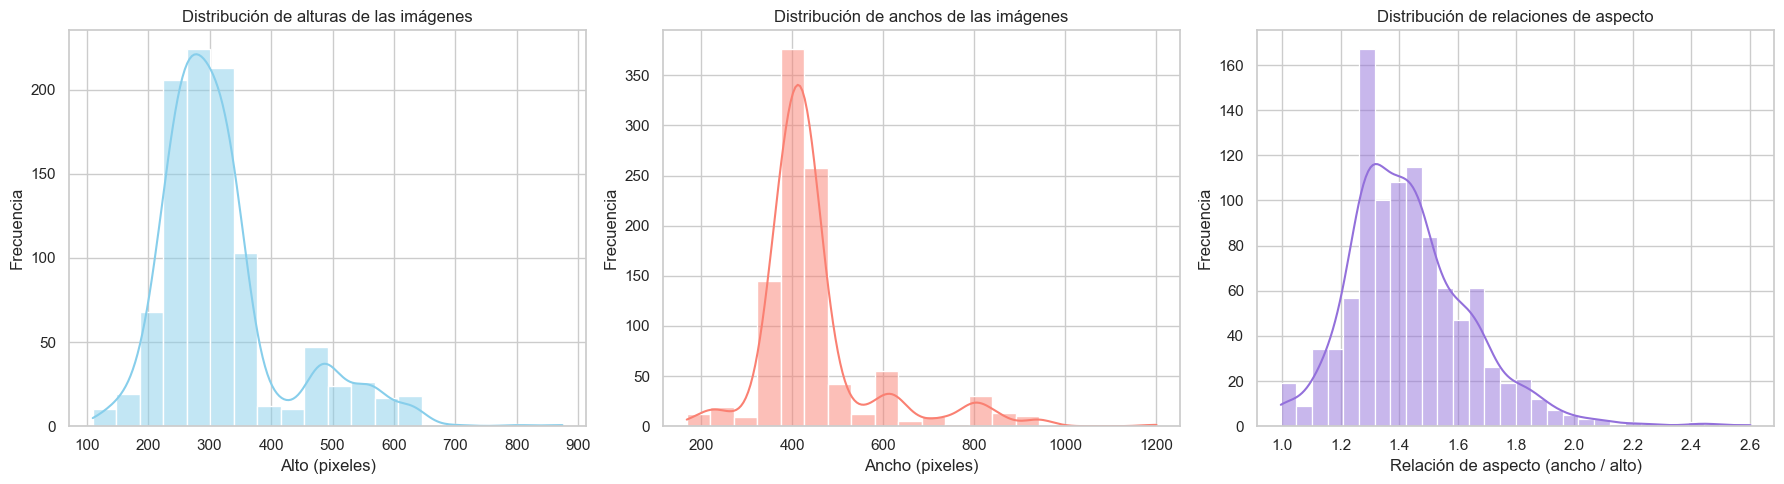

In [38]:
# Estilo general
sns.set(style="whitegrid")

# Crear figura con dos subgr√°ficos
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de alturas
sns.histplot(data=df_dims, x="height", bins=20, kde=True, ax=axs[0], color="skyblue")
axs[0].set_title("Distribuci√≥n de alturas de las im√°genes")
axs[0].set_xlabel("Alto (pixeles)")
axs[0].set_ylabel("Frecuencia")

# Histograma de anchos
sns.histplot(data=df_dims, x="width", bins=20, kde=True, ax=axs[1], color="salmon")
axs[1].set_title("Distribuci√≥n de anchos de las im√°genes")
axs[1].set_xlabel("Ancho (pixeles)")
axs[1].set_ylabel("Frecuencia")

# Graficar histograma
sns.histplot(data=df_dims, x="aspect_ratio", bins=30, kde=True, color="mediumpurple")
axs[2].set_title("Distribuci√≥n de relaciones de aspecto")
axs[2].set_xlabel("Relaci√≥n de aspecto (ancho / alto)")
axs[2].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


---

Se analizaron las dimensiones (alto y ancho) de todas las im√°genes de los subconjuntos `train`, `valid` y `test` con el objetivo de caracterizar la variabilidad presente en el dataset.

Se presentan a continuaci√≥n tres histogramas que reflejan la distribuci√≥n de:

- Alturas (en p√≠xeles)
- Anchos (en p√≠xeles)
- Relaciones de aspecto (ancho / alto)

Las distribuciones de alto y ancho evidencian una concentraci√≥n de valores entre 250‚Äì350 px de alto y 350‚Äì500 px de ancho, con algunos valores at√≠picos en los extremos.

Dado que las im√°genes presentan tama√±os heterog√©neos, **es necesario redimensionarlas a una resoluci√≥n unificada**

En cuanto a la relaci√≥n de aspecto, se observa una distribuci√≥n centrada aproximadamente en 1.4, con una dispersi√≥n moderada. Esto indica que la mayor√≠a de las im√°genes tienen proporciones similares, por lo que **es conveniente conservar dicha proporci√≥n durante el redimensionamiento**

---

## Histograma de intensidades por clase

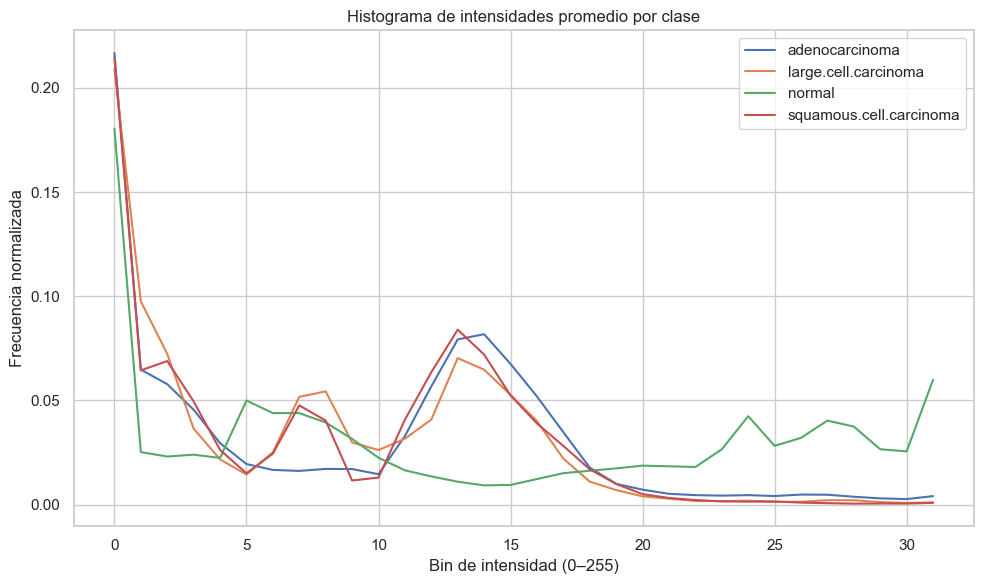

In [39]:
def obtener_histogramas(dataset_root, splits, labels, bins=32):
    hist_por_clase = {label: [] for label in labels}

    for split in splits:
        for label in labels:
            folder = dataset_root / split / label
            if not folder.exists():
                continue
            image_files = sorted([f for f in folder.iterdir() if f.is_file()])
            for img_path in image_files:
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
                    hist = hist.flatten() / hist.sum()  # normalizar
                    hist_por_clase[label].append(hist)

    # Calcular histograma promedio por clase
    hist_promedios = {
        label: np.mean(hist_por_clase[label], axis=0) for label in labels
    }

    return hist_promedios

# Calcular
hist_prom = obtener_histogramas(dataset_root, splits, labels, bins=32)

# Graficar
plt.figure(figsize=(10, 6))
for label, hist in hist_prom.items():
    plt.plot(hist, label=label)

plt.title("Histograma de intensidades promedio por clase")
plt.xlabel("Bin de intensidad (0‚Äì255)")
plt.ylabel("Frecuencia normalizada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---

Se calcularon histogramas de intensidad promedio para cada clase, dividiendo el rango tonal [0‚Äì255] en 32 intervalos (bins). Esta visualizaci√≥n permite comparar las distribuciones de niveles de gris presentes en las im√°genes.

Los resultados muestran que todas las clases presentan una gran concentraci√≥n de valores en los bins m√°s bajos, reflejando la presencia dominante de fondo negro. No obstante, se observan diferencias:

- La clase **normal** presenta mayor proporci√≥n de valores altos, lo cual puede deberse a una delimitaci√≥n m√°s clara entre pulm√≥n y fondo.
- Las clases cancerosas muestran una mayor proporci√≥n de intensidades intermedias, posiblemente asociadas a regiones de masa o tejido afectado.
- La forma general de los histogramas var√≠a sutilmente entre clases, lo que indica que **la distribuci√≥n de intensidades es una fuente potencial de discriminaci√≥n** entre ellas.

Estas diferencias refuerzan la utilidad de incluir histogramas de intensidad como parte de las features del modelo tradicional.

---


## An√°lisis del balance de clases

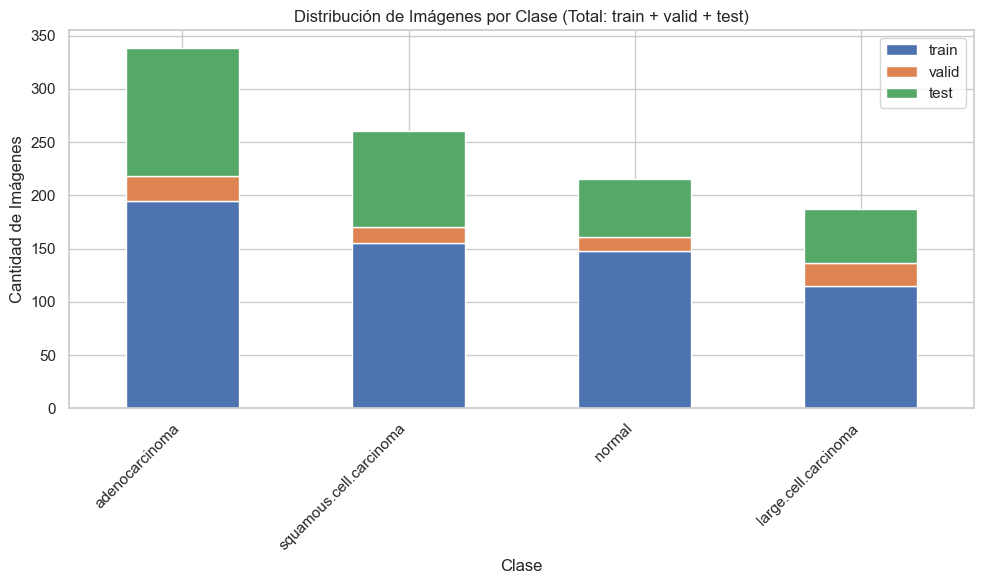

train  valid  test  total
adenocarcinoma             195     23   120    338
squamous.cell.carcinoma    155     15    90    260
normal                     148     13    54    215
large.cell.carcinoma       115     21    51    187

In [40]:
subsets = ["train", "valid", "test"]
class_distribution = defaultdict(lambda: {"train": 0, "valid": 0, "test": 0})

for subset in subsets:
    subset_path = os.path.join(dataset_root, subset)
    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_distribution[class_name][subset] = count

# Convertir a DataFrame
df_balance = pd.DataFrame(class_distribution).T.fillna(0).astype(int)
df_balance["total"] = df_balance.sum(axis=1)
df_balance = df_balance.sort_values("total", ascending=False)

# Graficar
df_balance[["train", "valid", "test"]].plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Distribuci√≥n de Im√°genes por Clase (Total: train + valid + test)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Im√°genes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Mostrar tabla
df_balance

---

An√°lisis de la distribuci√≥n de clases

- El conjunto de datos presenta un desbalance moderado entre clases:
  - Adenocarcinoma (`338` im√°genes) es la clase con mayor cantidad total de muestras.
  - Le siguen Squamous cell carcinoma (`260`) y Normal (`215`).
  - Large cell carcinoma (`187`) es la clase con menor representaci√≥n.

- Aunque el conjunto `train` mantiene una distribuci√≥n relativamente balanceada entre clases, las diferencias se amplifican al considerar la suma total (`train` + `valid` + `test`), lo cual podr√≠a impactar negativamente en el rendimiento del modelo sobre clases con menor representaci√≥n.

---

## Diagrama de caja y bigote de la intensidad media por clase

Estad√≠sticas de Intensidad y Tama√±os por Clase:

                           mean    std  min  max   width  height
class                                                           
adenocarcinoma            82.60  54.65    0  255  385.57  258.27
large.cell.carcinoma      62.47  46.51    0  255  398.53  259.74
normal                   113.89  80.51    0  255  572.24  429.97
squamous.cell.carcinoma   66.72  46.33    0  255  396.50  271.38


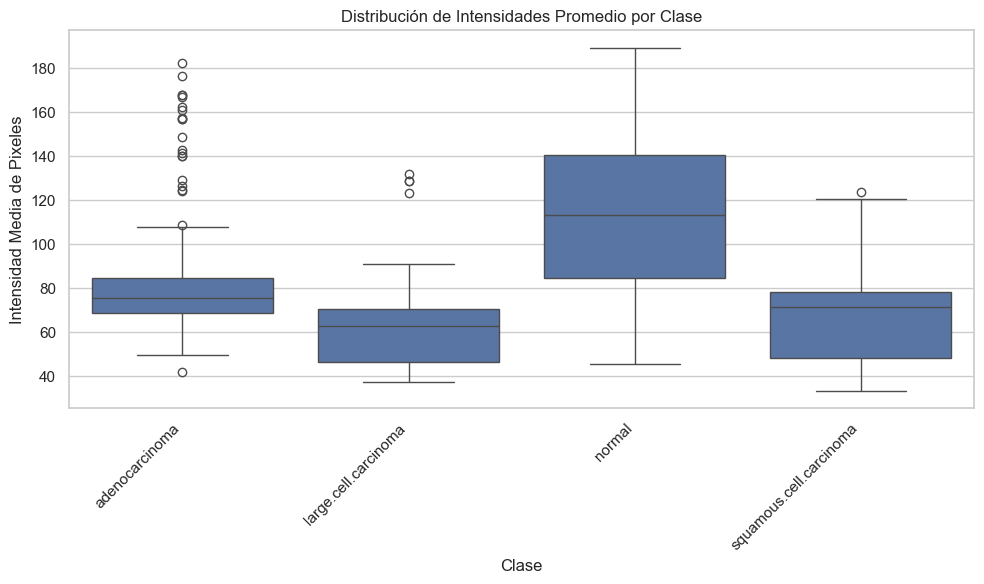

In [41]:
# Analizar dimensiones y estad√≠sticas de intensidad por clase
image_shapes = []
intensity_stats = []

# Vamos a recorrer s√≥lo el conjunto de entrenamiento (train) para este an√°lisis
subset = "train"
subset_path = os.path.join(".", "Data", subset)

for class_name in os.listdir(subset_path):
    class_path = os.path.join(subset_path, class_name)
    if not os.path.isdir(class_path):
        continue
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).convert("L")  # Escala de grises
            img_array = np.array(img)

            # Guardar dimensiones
            image_shapes.append(img_array.shape)

            # Guardar estad√≠sticas
            intensity_stats.append({
                "class": class_name,
                "mean": img_array.mean(),
                "std": img_array.std(),
                "min": img_array.min(),
                "max": img_array.max(),
                "width": img_array.shape[1],
                "height": img_array.shape[0]
            })

# Convertir a DataFrame
intensity_df = pd.DataFrame(intensity_stats)
# Agrupamos por clase y mostramos estad√≠sticos promedio
summary_df = intensity_df.groupby("class").agg({
    "mean": "mean",
    "std": "mean",
    "min": "min",
    "max": "max",
    "width": "mean",
    "height": "mean"
}).round(2)

# Mostrar el resultado
print("Estad√≠sticas de Intensidad y Tama√±os por Clase:\n")
print(summary_df)

selected_classes = intensity_df['class'].unique()

# Crear histograma de intensidades promedio por clase
plt.figure(figsize=(10, 6))
sns.boxplot(data=intensity_df, x="class", y="mean")
plt.title("Distribuci√≥n de Intensidades Promedio por Clase")
plt.ylabel("Intensidad Media de Pixeles")
plt.xlabel("Clase")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

---

El gr√°fico de cajas muestra la distribuci√≥n de la intensidad promedio de p√≠xeles por clase en el conjunto de entrenamiento:

- Normal: Tiene las intensidades m√°s altas (mediana > 110), con una amplia dispersi√≥n y varios valores at√≠picos por encima de 180. Esto indica una mayor luminosidad general en pulmones sanos.
- Adenocarcinoma y Squamous cell carcinoma: Presentan medianas entre 70 y 80, con distribuci√≥n m√°s compacta. Reflejan menor brillo debido a la presencia de masas o lesiones.
- Large cell carcinoma: Es la clase con menor intensidad media (mediana < 70), lo que podr√≠a asociarse a im√°genes m√°s oscuras o tumores densos.

La intensidad promedio puede ser un buen descriptor para distinguir entre im√°genes normales y patol√≥gicas, aunque entre subtipos de c√°ncer hay solapamientos.

---

## An√°lisis de la desviaci√≥n est√°ndar por clase

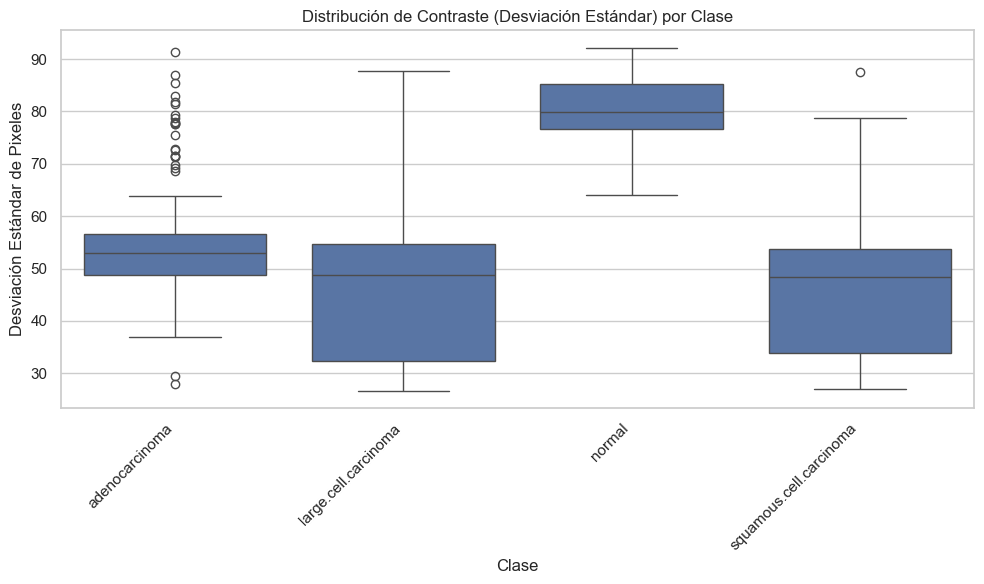

In [42]:
# Histograma de la desviaci√≥n est√°ndar por clase
plt.figure(figsize=(10, 6))
sns.boxplot(data=intensity_df, x="class", y="std")
plt.title("Distribuci√≥n de Contraste (Desviaci√≥n Est√°ndar) por Clase")
plt.ylabel("Desviaci√≥n Est√°ndar de Pixeles")
plt.xlabel("Clase")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

---

Este gr√°fico muestra la variabilidad en la intensidad de p√≠xeles, lo que se traduce en el **contraste** de las im√°genes:

- Normal: Presenta la mayor dispersi√≥n de valores (`std ‚âà 75‚Äì90`), lo que indica im√°genes m√°s ricas en variaciones de gris. Esto es consistente con pulmones sanos que contienen m√°s detalles estructurales visibles.
- Clases patol√≥gicas (adenocarcinoma, large cell, squamous cell): Tienen menor contraste, con medianas entre `50‚Äì55`, lo que puede deberse a la homogeneidad visual de las lesiones.
- Large cell carcinoma: Se destaca por su menor rango de variaci√≥n (`std ‚âà 30‚Äì60`), lo que puede indicar lesiones m√°s opacas o compactas.

Las im√°genes normales tienden a tener mayor contraste, lo cual puede ser √∫til para diferenciarlas autom√°ticamente de las patol√≥gicas.

---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Baseline</h1>
</div>

## Extracci√≥n de caracter√≠sticas visuales y construcci√≥n del clasificador

---
En esta secci√≥n se implementar√° una estrategia de clasificaci√≥n basada en t√©cnicas cl√°sicas de visi√≥n por computadora. Se utilizar√°n caracter√≠sticas visuales derivadas del an√°lisis exploratorio de datos realizado previamente, donde se construyeron histogramas y diagramas de caja para evaluar la intensidad y el contraste de las im√°genes.

A partir de dicho an√°lisis, se concluy√≥ que las im√°genes correspondientes a personas sanas tienden a presentar mayor contraste y mejor iluminaci√≥n, mientras que las im√°genes de pacientes con diagn√≥stico presentan tonalidades m√°s oscuras.

Estas observaciones motivan la extracci√≥n de caracter√≠sticas estad√≠sticas (como brillo promedio, desviaci√≥n est√°ndar, contraste, entre otras) que ser√°n utilizadas como variables explicativas en un clasificador Random Forest. Este modelo cl√°sico de machine learning servir√° como l√≠nea base para comparar con enfoques basados en aprendizaje profundo.

---


In [43]:
def extraer_features(dataset_root, splits, labels, target_size=(224, 224), bins=16):
    datos_por_split = {}

    for split in splits:
        registros = []
        for label in labels:
            folder = dataset_root / split / label
            if not folder.exists():
                continue
            image_files = sorted([f for f in folder.iterdir() if f.is_file()])
            for img_path in tqdm(image_files, desc=f"{split}/{label}"):
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                # Aspect ratio original
                aspect_ratio = img.shape[1] / img.shape[0]

                # Redimensionar
                img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

                # Features globales
                mean_intensity = np.mean(img_resized)
                std_intensity = np.std(img_resized)
                range_intensity = np.max(img_resized) - np.min(img_resized)

                # Histograma normalizado
                hist = cv2.calcHist([img_resized], [0], None, [bins], [0, 256])
                hist = (hist / hist.sum()).flatten()

                # Armar registro
                features = {
                    "mean_intensity": mean_intensity,
                    "std_intensity": std_intensity,
                    "range_intensity": range_intensity,
                    "aspect_ratio": aspect_ratio,
                    "label": label
                }

                # Agregar bins como columnas separadas
                for i in range(bins):
                    features[f"hist_bin_{i}"] = hist[i]

                registros.append(features)

        # Guardar DataFrame del split
        datos_por_split[split] = pd.DataFrame(registros)

    return datos_por_split.get("train"), datos_por_split.get("valid"), datos_por_split.get("test")

splits = ["train", "valid", "test"]
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

df_train, df_valid, df_test = extraer_features(dataset_root, splits, labels)

test/squamous.cell.carcinoma: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 90/90 [00:00<00:00, 271.33it/s]


## Entrenamiento del modelo Random Forest

No se encontr√≥ un modelo guardado. Entrenando un nuevo modelo...
Modelo guardado como random_forest_baseline_no_optimizado.pkl
Classification Report (F1):

                         precision    recall  f1-score   support

         adenocarcinoma       0.64      0.78      0.71        23
   large.cell.carcinoma       0.69      0.43      0.53        21
                 normal       1.00      0.85      0.92        13
squamous.cell.carcinoma       0.45      0.60      0.51        15

               accuracy                           0.65        72
              macro avg       0.70      0.66      0.67        72
           weighted avg       0.68      0.65      0.65        72

F2 score (ponderado): 0.6497


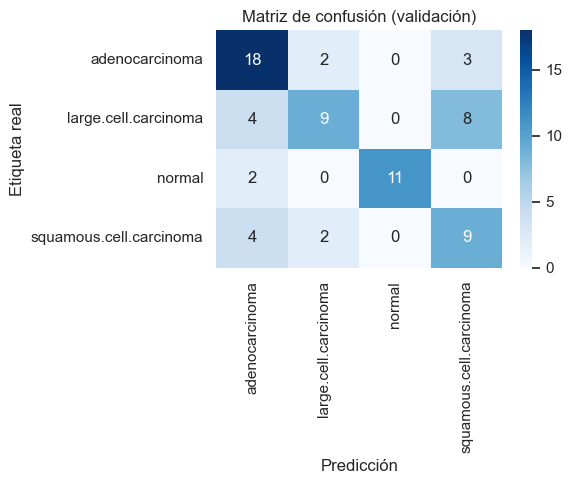

In [44]:
# Si hay un modelo guardado, lo cargamos
if os.path.exists("random_forest_baseline_no_optimizado.pkl"):
    print("Cargando modelo guardado...")
    clf = joblib.load("random_forest_baseline_no_optimizado.pkl")
    print("Modelo cargado correctamente.")
else:
    print("No se encontr√≥ un modelo guardado. Entrenando un nuevo modelo...")


    # Codificar etiquetas
    le = LabelEncoder()
    df_train["label_encoded"] = le.fit_transform(df_train["label"])
    df_valid["label_encoded"] = le.transform(df_valid["label"])

    # Separar features y etiquetas
    X_train = df_train.drop(columns=["label", "label_encoded"])
    y_train = df_train["label_encoded"]

    X_valid = df_valid.drop(columns=["label", "label_encoded"])
    y_valid = df_valid["label_encoded"]

    # Entrenar modelo
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predicci√≥n
    y_pred = clf.predict(X_valid)
    
    # Guardar modelo en disco
    joblib.dump(clf, "random_forest_baseline_no_optimizado.pkl")
    print("Modelo guardado como random_forest_baseline_no_optimizado.pkl")

# M√©tricas
print("Classification Report (F1):\n")
print(classification_report(y_valid, y_pred, target_names=le.classes_))

f2 = fbeta_score(y_valid, y_pred, beta=2, average="weighted")
print(f"F2 score (ponderado): {f2:.4f}")



# Matriz de confusi√≥n
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de confusi√≥n (validaci√≥n)")
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Se entrena un modelo Random Forest utilizando los par√°metros por defecto del clasificador. Las etiquetas fueron codificadas con `LabelEncoder` y se utilizaron las caracter√≠sticas extra√≠das previamente como variables de entrada. En esta etapa se realiza la predicci√≥n sobre el conjunto de validaci√≥n y se reportan las m√©tricas de desempe√±o junto con la matriz de confusi√≥n.

---

## Evaluaci√≥n del modelo sobre el conjunto de test

Evaluaci√≥n en conjunto de test:

                         precision    recall  f1-score   support

         adenocarcinoma       0.40      0.28      0.33       120
   large.cell.carcinoma       0.27      0.78      0.41        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.53      0.18      0.27        90

               accuracy                           0.45       315
              macro avg       0.55      0.56      0.50       315
           weighted avg       0.52      0.45      0.44       315

F2 score (ponderado, test): 0.4344


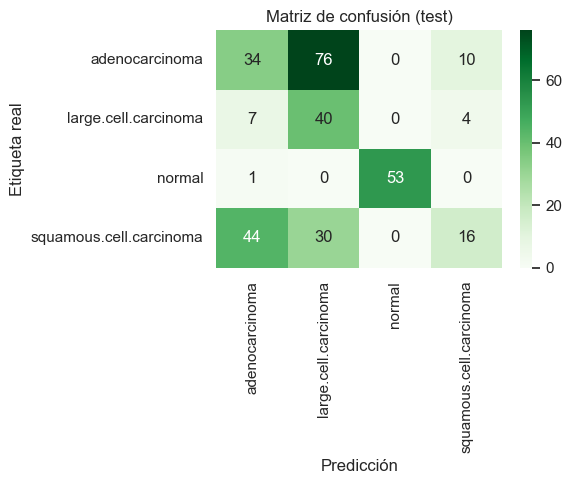

In [45]:
# Codificar etiquetas reales del test (usando el LabelEncoder entrenado)
df_test["label_encoded"] = le.transform(df_test["label"])

# Separar features y etiquetas
X_test = df_test.drop(columns=["label", "label_encoded"])
y_test = df_test["label_encoded"]

# Cargar modelo entrenado
clf = joblib.load("random_forest_baseline_no_optimizado.pkl")

# Predicci√≥n
y_pred_test = clf.predict(X_test)

# Reporte
print("Evaluaci√≥n en conjunto de test:\n")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

f2_test = fbeta_score(y_test, y_pred_test, beta=2, average="weighted")
print(f"F2 score (ponderado, test): {f2_test:.4f}")

# Matriz de confusi√≥n
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.title("Matriz de confusi√≥n (test)")
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Una vez entrenado el modelo sobre los conjuntos `train` y `validaci√≥n`, se procede a evaluar su desempe√±o sobre el conjunto de `test`, que no fue utilizado en ninguna etapa previa del entrenamiento.

Se aplican las mismas transformaciones sobre las caracter√≠sticas y etiquetas y se reportan las m√©tricas de clasificaci√≥n y la matriz de confusi√≥n correspondiente. Esta evaluaci√≥n permite obtener una estimaci√≥n m√°s objetiva del rendimiento del modelo ante datos no vistos.

---

## Entrenamiento con b√∫squeda de hiperpar√°metros

In [46]:
if os.path.exists("random_forest_baseline_optimizado.pkl"):
    print("Cargando modelo optimizado guardado...")
    best_clf = joblib.load("random_forest_baseline_optimizado.pkl")
    print("Modelo optimizado cargado correctamente.")
    print("Mejores hiperpar√°metros:", best_clf.get_params())
else:
    print("No se encontr√≥ un modelo optimizado guardado. Entrenando un nuevo modelo optimizado...")

    # Separar features y etiquetas (como antes)
    X_train = df_train.drop(columns=["label", "label_encoded"])
    y_train = df_train["label_encoded"]

    # Definir m√©trica F2 como funci√≥n para grid search
    f2_scorer = make_scorer(fbeta_score, beta=2, average="weighted")

    # Grilla de hiperpar√°metros
    param_grid = {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["balanced"] # fuerza a considerar pesos autom√°ticos por clase
    }


    # Validaci√≥n cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar b√∫squeda
    grid_search.fit(X_train, y_train)

    # Mejor modelo
    best_clf = grid_search.best_estimator_
    print("Mejores hiperpar√°metros:", grid_search.best_params_)
    
    print("Guardando modelo optimizado...")
    # Guardar modelo optimizado
    joblib.dump(best_clf, "random_forest_baseline_optimizado.pkl")
    print("Modelo optimizado guardado como random_forest_baseline_optimizado.pkl")



No se encontr√≥ un modelo optimizado guardado. Entrenando un nuevo modelo optimizado...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperpar√°metros: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Guardando modelo optimizado...
Modelo optimizado guardado como random_forest_baseline_optimizado.pkl


Cargando modelo optimizado guardado...
Modelo optimizado cargado correctamente.
Classification Report (F1):

                         precision    recall  f1-score   support

         adenocarcinoma       0.64      0.78      0.71        23
   large.cell.carcinoma       0.69      0.43      0.53        21
                 normal       1.00      0.85      0.92        13
squamous.cell.carcinoma       0.45      0.60      0.51        15

               accuracy                           0.65        72
              macro avg       0.70      0.66      0.67        72
           weighted avg       0.68      0.65      0.65        72

F2 score (ponderado): 0.6497


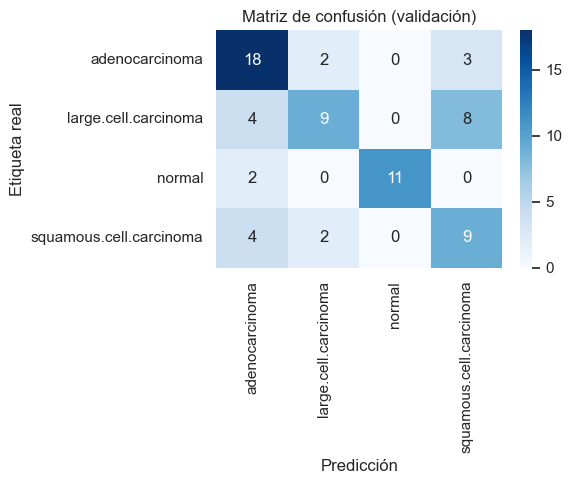

In [47]:

# Si hay un modelo guardado, lo cargamos
if os.path.exists("random_forest_baseline_optimizado.pkl"):
    print("Cargando modelo optimizado guardado...")
    best_clf = joblib.load("random_forest_baseline_optimizado.pkl")
    print("Modelo optimizado cargado correctamente.")
else:
    print("No se encontr√≥ un modelo optimizado guardado. Entrenando un nuevo modelo...")


    # Codificar etiquetas
    le = LabelEncoder()
    df_train["label_encoded"] = le.fit_transform(df_train["label"])
    df_valid["label_encoded"] = le.transform(df_valid["label"])

    # Separar features y etiquetas
    X_train = df_train.drop(columns=["label", "label_encoded"])
    y_train = df_train["label_encoded"]

    X_valid = df_valid.drop(columns=["label", "label_encoded"])
    y_valid = df_valid["label_encoded"]

    # Entrenar modelo optimizado
    
    best_clf.fit(X_train, y_train)

    # Predicci√≥n
    y_pred = best_clf.predict(X_valid)
    
    # Guardar modelo en disco
    joblib.dump(best_clf, "random_forest_baseline_optimizado.pkl")
    print("Modelo guardado como random_forest_baseline_optimizado.pkl")

# M√©tricas
print("Classification Report (F1):\n")
print(classification_report(y_valid, y_pred, target_names=le.classes_))

f2 = fbeta_score(y_valid, y_pred, beta=2, average="weighted")
print(f"F2 score (ponderado): {f2:.4f}")



# Matriz de confusi√≥n
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de confusi√≥n (validaci√≥n)")
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Se entrena un modelo Random Forest aplicando b√∫squeda de hiperpar√°metros con `GridSearchCV`. El procedimiento consiste en explorar distintas combinaciones de par√°metros como `n_estimators`, `max_depth` y `criterion`, evaluando el desempe√±o mediante validaci√≥n cruzada.

Se incluye adem√°s la opci√≥n `class_weight='balanced'` para compensar el desbalance de clases ajustando los pesos seg√∫n la frecuencia relativa de cada clase.

Una vez finalizada la b√∫squeda, se entrena el mejor modelo sobre el conjunto de entrenamiento completo.

---

## Evaluaci√≥n del modelo optimizado

Evaluaci√≥n en conjunto de test:

                         precision    recall  f1-score   support

         adenocarcinoma       0.39      0.32      0.35       120
   large.cell.carcinoma       0.27      0.73      0.39        51
                 normal       1.00      0.96      0.98        54
squamous.cell.carcinoma       0.52      0.17      0.25        90

               accuracy                           0.45       315
              macro avg       0.54      0.54      0.49       315
           weighted avg       0.51      0.45      0.44       315

F2 score (ponderado, test): 0.4347


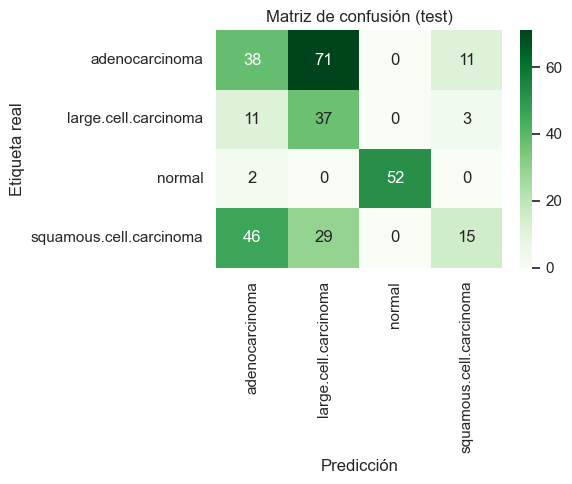

In [48]:
# Codificar etiquetas reales del test (usando el LabelEncoder entrenado)
df_test["label_encoded"] = le.transform(df_test["label"])

# Separar features y etiquetas
X_test = df_test.drop(columns=["label", "label_encoded"])
y_test = df_test["label_encoded"]

# Cargar modelo entrenado
best_clf = joblib.load("random_forest_baseline_optimizado.pkl")

# Predicci√≥n
y_pred_test = best_clf.predict(X_test)

# Reporte
print("Evaluaci√≥n en conjunto de test:\n")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

f2_test = fbeta_score(y_test, y_pred_test, beta=2, average="weighted")
print(f"F2 score (ponderado, test): {f2_test:.4f}")

# Matriz de confusi√≥n
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.title("Matriz de confusi√≥n (test)")
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()


---

Finalizado el entrenamiento del modelo con los mejores hiperpar√°metros encontrados, se eval√∫a su desempe√±o sobre el conjunto de validaci√≥n.

Se reportan las m√©tricas de clasificaci√≥n (precisi√≥n, recall, F1-score) y la matriz de confusi√≥n, lo que permite comparar los resultados obtenidos frente al modelo base entrenado con los par√°metros por defecto.

---

## An√°lisis de resultados

---

El modelo Random Forest basado en caracter√≠sticas visuales extra√≠das manualmente logr√≥ un desempe√±o aceptable en validaci√≥n (F‚ÇÇ = 0.66), aunque present√≥ una ca√≠da importante en el conjunto de test (F‚ÇÇ = 0.43), lo que indica una capacidad limitada de generalizaci√≥n.

El an√°lisis de errores revela que el modelo distingue con mayor claridad la clase ‚Äúnormal‚Äù, pero muestra dificultades para diferenciar entre los distintos subtipos de enfermedad pulmonar, evidenciando confusi√≥n entre clases patol√≥gicas.

El modelo final utiliz√≥ los mejores hiperpar√°metros encontrados mediante b√∫squeda en grilla, incluyendo una profundidad m√°xima moderada y el ajuste de pesos por clase (`class_weight='balanced'`).

Este comportamiento sugiere que las caracter√≠sticas estad√≠sticas extra√≠das (intensidad, contraste, etc.) no son suficientes para capturar la complejidad visual presente en las im√°genes. Por ello, se propone avanzar hacia un enfoque basado en redes neuronales convolucionales preentrenadas mediante *transfer learning*, que permitir√°n extraer representaciones m√°s descriptivas y discriminativas, especialmente √∫tiles para clasificar correctamente las clases con mayor solapamiento visual.

---

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #2e8b57; padding: 10px; background-color: #b9fbc0; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #2e8b57; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Conclusiones parciales y pr√≥ximos pasos</h1>
</div>

---

En una primera versi√≥n de este trabajo, se abord√≥ directamente la clasificaci√≥n de im√°genes mediante redes neuronales convolucionales preentrenadas sobre datasets gen√©ricos de gran escala, como *ImageNet* (con m√°s de 1.4 millones de im√°genes). Esta elecci√≥n result√≥ inadecuada debido a dos limitaciones centrales:

- *ImageNet* no est√° compuesto por im√°genes m√©dicas, lo cual debilita la transferencia de conocimiento hacia el dominio cl√≠nico.
- El conjunto de datos local disponible contiene apenas ~1000 im√°genes, lo que vuelve insuficiente el fine-tuning profundo sobre modelos tan complejos.

Frente a estas observaciones, se decidi√≥ replantear el enfoque del proyecto. A partir de all√≠ se propuso incorporar una l√≠nea base m√°s robusta, desarrollada con t√©cnicas cl√°sicas de visi√≥n por computadora y un modelo `RandomForestClassifier` sobre caracter√≠sticas manuales extra√≠das del EDA.

Este cambio metodol√≥gico permiti√≥ no solo establecer un punto de comparaci√≥n m√°s realista, sino tambi√©n valorar los l√≠mites de las estrategias cl√°sicas. El an√°lisis evidenci√≥ que, aunque el modelo cl√°sico logra detectar adecuadamente casos normales, no resulta suficiente para diferenciar entre subtipos patol√≥gicos.

A partir de este aprendizaje, los pr√≥ximos pasos retoman el uso de redes convolucionales, ahora con mayor justificaci√≥n t√©cnica y con objetivos m√°s claros:

- Implementar redes convolucionales preentrenadas sobre datasets m√©dicos, ajustando sus capas finales mediante *fine-tuning*.
- Aplicar t√©cnicas de aumento de datos moderadas (rotaciones, volteos) para mitigar el bajo volumen del dataset sin distorsionar la naturaleza de las im√°genes m√©dicas.
- Evaluar el rendimiento utilizando la m√©trica F-beta (con Œ≤=2), que prioriza la reducci√≥n de falsos negativos por su relevancia cl√≠nica.
- Realizar inferencia sobre el conjunto de test y an√°lisis detallado por clase.
- Generar gr√°ficos de evoluci√≥n de m√©tricas (`loss`, `accuracy`, `F-beta`) durante entrenamiento y validaci√≥n.
- Explorar nuevas estrategias de mejora como reconfiguraci√≥n de hiperpar√°metros, t√©cnicas avanzadas de balanceo de clases y ajustes espec√≠ficos por arquitectura.

Este proceso de iteraci√≥n y reformulaci√≥n constituye un aprendizaje clave del trabajo, al poner en evidencia la importancia de una l√≠nea base bien construida y la necesidad de adaptar las herramientas de aprendizaje profundo a las particularidades del dominio m√©dico.

---


